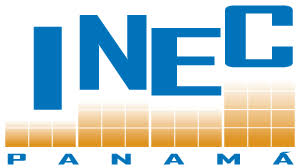
# Evaluación

Esta librería realiza la evaluación de las proyecciones a frecuencia mensual.

# Librerías

Se importan las librerías necesarias para realizar el manejo de base de datos y/o proyecciones del modelos.

- pykalman: Librería de filtro de kalman en python.
- pandas: Manejo de bases de datos
- datetime: Manejo de fechas
- numpy: Manejo de matrices
- matploblib.pyplot: Gráficos
- os: Manejo de rutas
- numdifftools: Libreria para calculo de gradientes y derivadas
- statsmodels.tsa.arima_model: Modelos de series de tiempo
- statsmodels.tsa.api: Gráfico de autocorrelaciones
- seaborn: Gráficos adicionales
- ipynb.fs.defs.ConstruccionBasedeDatos: Función definida en el programa ConstruccionBasedeDatos para construir el insumo para hacer la estimación/proyección.
- ipynb.fs.defs.m1Kalman: Filtro de kalman para interpolar
- ipynb.fs.defs.p2InterpolacionProyeccion: Construcción de estadísticos para realizar la evaluación

In [31]:
import pandas as pd
#Comentario
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import seaborn as sns
from ipynb.fs.defs.ConstruccionBasedeDatos import BasedeDatos
from ipynb.fs.defs.m1Kalman import interpol
from ipynb.fs.defs.p2InterpolacionProyeccion import kalman_resultados
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Rutas para guardar inputs/outputs

In [32]:
rutaOrigen = 'inputs/'
rutaEstimacion = 'model_interpol/'
rutaDestino = 'resultados/'

# Construcción de Base de datos

In [33]:
_,_,_,bd_all = BasedeDatos(rutaOrigen + 'bd_Panama.xlsx')
#Añadiendo constante
bd_all['cons'] = 1

C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Evaluación

En esta sección se evalúa el desempeño del modelo estimado, proyectando el PIB con un periodo de adelanto y comparándolo con el dato ejecutado y se muestran los estadísticos de desempeño de estas proyecciones (Error Absoluto Medio (MAE), R2, la raíz del error cuadrático medio (RMSE)).

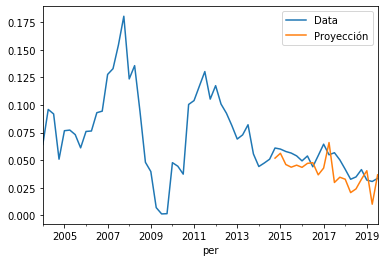

In [34]:
VariablesPBI = ['pbif_Trimestre_VariacionAnual',
               ]

bd_eval = {}
models = {}
#Test size
test_size_eval=60
#Frecuencias de variables
frq1 = 3
frq2 = 1

for y in VariablesPBI:
    
    NombreVariableFrecuencia1Filtrada = y[0:6] + '_VariacionFrecuencia1_Filtrada'
    NombreVariableFrecuencia2Filtrada = y[0:6] + '_VariacionFrecuencia2_Filtrada'

    NombreVariableFrecuencia1Imputada = y[0:6] + '_VariacionFrecuencia1_Imputada'
    NombreVariableFrecuencia2Imputada = y[0:6] + '_VariacionFrecuencia2_Imputada'
    
    bd_pred_1s = pd.DataFrame()
    
    for test_size in range(test_size_eval,0,-1):

        BaseInterpolacion,_,_ = kalman_resultados(rutaEstimacion + 'ModelosKalman.xlsx', bd_all, y, frq1, frq2,test_size)

        if test_size>0:

            bd_pred = BaseInterpolacion[[y + '_data'] + [NombreVariableFrecuencia2Imputada]][-test_size:]
            bd_pred = bd_pred[bd_pred[y + '_data'] != 0].dropna()
            bd_pred = bd_pred[:1]
 
            if len(bd_pred.index.tolist())>0:
                if not(bd_pred.index[0] in bd_pred_1s.index):
                    bd_pred_1s = bd_pred_1s.append(bd_pred)
    
    bd_eval[y] = {'MAE': mean_absolute_error(bd_pred_1s[y + '_data'],bd_pred_1s[NombreVariableFrecuencia2Imputada]),
                    'R2': r2_score(bd_pred_1s[y + '_data'],bd_pred_1s[NombreVariableFrecuencia2Imputada]),
                    'RMSE': mean_squared_error(bd_pred_1s[y + '_data'],bd_pred_1s[NombreVariableFrecuencia2Imputada])**0.5
                   }
    
    BaseInterpolacion.loc[BaseInterpolacion[y + '_data'] != 0,[y + '_data']].join(bd_pred_1s.drop([y + '_data'], axis =1)).plot()
    plt.legend(['Data','Proyección'])
    
    plt.show()


In [35]:
with pd.ExcelWriter(rutaDestino + 'evalInterpol.xlsx') as writer:
    BaseInterpolacion.loc[BaseInterpolacion[y + '_data'] != 0,[y + '_data']].join(bd_pred_1s.drop([y + '_data'], axis =1)).to_excel(writer, sheet_name='Proyecciones Interpol')

In [30]:
pd.DataFrame(bd_eval).transpose()

,MAE,R2,RMSE
pbif_Trimestre_VariacionAnual,0.00951,-0.230432,0.011585


# Resultados

Se muestran los resultados del modelo estimado, los parámetros y los estadísticos T asociados.

#### Modelo estimado

In [7]:
model = 0
VariablesPBI[model]
frq1 = 3
frq2 = 1
test_size=32

bd_model = pd.read_excel(rutaEstimacion + 'ModelosKalman.xlsx',sheet_name = VariablesPBI[model][0:20], index_col = 0 )

y = [VariablesPBI[model]]
X = bd_model.index[3:].tolist()

ParametrosOptimizados = bd_model.Valor.values.tolist()

display(bd_model)

,Valor,STD,T
Phi,-0.539174,0.337714,-1.596539
Rho,0.914215,0.044263,20.654074
Sigma^2,0.000041,0.000014,3.008533
ipc1_viv_12Meses_VariacionAnual,0.158254,0.132944,1.190375
ipc1_trp_12Meses_VariacionAnual,0.056107,0.086902,0.645633
cons,0.032211,0.011226,2.869283


# Interpolación - Detallada

##### Filtro de Kalman

Se muestran el detalle de los resultados de la evaluación, como la serie a interpolar, las variables usadas para la interpolación y los resultados a diferentes frecuencias: anuales, trimestrales y mensuales.

In [8]:
_, KalmanInterpolador, BaseInterpolacion = interpol(bd_all,X,y,frq1,frq2,ParametrosOptimizados,test_size)

###### Serie Usada

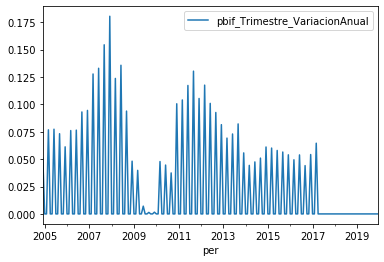

In [9]:
BaseInterpolacion[y].plot()

##### Construyendo variables de distintas frecuencias (Mensual/Trimestral)

In [10]:
NombreVariableFrecuencia1Filtrada = y[0][0:6] + '_VariacionFrecuencia1_Filtrada'
NombreVariableFrecuencia2Filtrada = y[0][0:6] + '_VariacionFrecuencia2_Filtrada'

NombreVariableFrecuencia1Imputada = y[0][0:6] + '_VariacionFrecuencia1_Imputada'
NombreVariableFrecuencia2Imputada = y[0][0:6] + '_VariacionFrecuencia2_Imputada'


BaseInterpolacion[NombreVariableFrecuencia1Filtrada] = pd.DataFrame(KalmanInterpolador.filter(BaseInterpolacion[y])[0]).set_index(BaseInterpolacion.index)[0] * frq1/frq2
BaseInterpolacion[NombreVariableFrecuencia2Filtrada] = BaseInterpolacion[NombreVariableFrecuencia1Filtrada].rolling(int(frq1/frq2)).mean()
BaseInterpolacion[NombreVariableFrecuencia1Imputada] = pd.DataFrame(KalmanInterpolador.smooth(BaseInterpolacion[y])[0]).set_index(BaseInterpolacion.index)[0] * frq1/frq2
BaseInterpolacion[NombreVariableFrecuencia2Imputada] = BaseInterpolacion[NombreVariableFrecuencia1Imputada].rolling(int(frq1/frq2)).mean()

###### Variables que interpolan

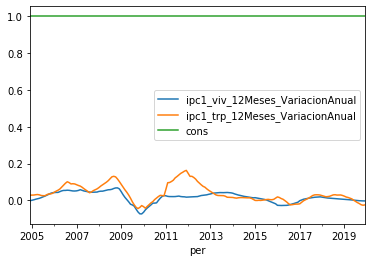

In [11]:
BaseInterpolacion[X].plot()

##### PIB Interpolacion - Crecimiento Anual

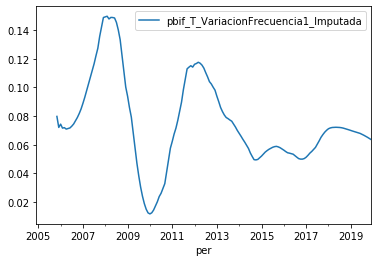

In [12]:
BaseInterpolacion[[NombreVariableFrecuencia1Imputada]].rolling(12).mean().plot()

###### PIB Interpolacion - Baja frecuencia (Trimestral)

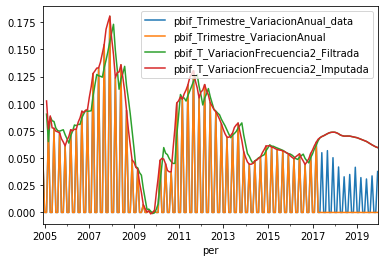

In [13]:
BaseInterpolacion[[y[0] + '_data'] + y + [NombreVariableFrecuencia2Filtrada,NombreVariableFrecuencia2Imputada]].plot()

###### PIB Interpolacion - Alta frecuencia (Mensual)

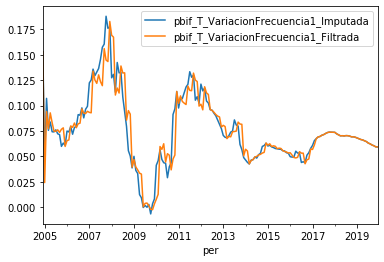

In [14]:
BaseInterpolacion[[NombreVariableFrecuencia1Imputada,NombreVariableFrecuencia1Filtrada]].plot()